In [5]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import *

from matplotlib import pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img)
  plt.axis('off')

import seaborn as sns
sns.set(font_scale=0.9)

def r(n):
  return round(float(n), 3)

def clip_percentile(img, p=0.1):
  return np.clip(img, np.percentile(img, p), np.percentile(img, 100-p))

from google.colab import drive
drive.mount('/content/drive/')

!cp -r "/content/drive/MyDrive/Revisiting Feature Viz/data/reference_spectrum" ./

<ipython-input-5-5256c16624e0>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Mounted at /content/drive/


In [6]:
from scipy.ndimage import gaussian_filter as gaussian
import PIL

def plot(t):
  """ Remove outlier and plot image """
  t = clip_percentile(t, 0.1)
  t -= t.mean(); t /= t.std()
  t -= t.min(); t /= t.max()
  plt.imshow(t)
  plt.axis('off')

def plot_alpha(t, tr):
  """ Remove outlier and plot image (take care of merging the alpha) """
  t = clip_percentile(img, 0.1)
  t -= t.mean(); t /= t.std()
  t -= t.min(); t /= t.max()

  tr = np.mean(tr, -1, keepdims=True)
  tr = gaussian(tr, sigma=50)
  tr = np.clip(tr, 0, np.percentile(tr, 75))
  tr /= tr.max()

  viz = np.concatenate([t, tr], -1)
  plt.imshow(viz)
  plt.axis('off')

  return viz

In [7]:
imagenet_color_correlation = tf.cast(
      [[0.56282854, 0.58447580, 0.58447580],
       [0.19482528, 0.00000000,-0.19482528],
       [0.04329450,-0.10823626, 0.06494176]], tf.float32
)

def recorrelate_colors(images):
    images_flat = tf.reshape(images, [-1, 3])
    images_flat = tf.matmul(images_flat, imagenet_color_correlation)
    return tf.reshape(images_flat, tf.shape(images))

In [8]:
#model = beit.BeitBasePatch16(input_shape=(384, 384, 3), pretrained="imagenet21k-ft1k", classifier_activation="linear")
flex = tf.keras.applications.ResNet50V2(classifier_activation=None)
model = tf.keras.Model(flex.input, flex.layers[-2].output)
#model = beit.BeitBasePatch16(input_shape=(384, 384, 3), pretrained="imagenet21k-ft1k", classifier_activation="linear")
MODEL_INPUT_SIZE = (224, 224)

102869336/102869336 [==============================] - 1s 0us/step


In [9]:
@tf.function
def cosine_similarity(tensor_a: tf.Tensor, tensor_b: tf.Tensor) -> tf.Tensor:
    tensor_a = tf.nn.l2_normalize(tensor_a, axis=-1)
    tensor_b = tf.nn.l2_normalize(tensor_b, axis=-1)
    return tf.reduce_sum(tensor_a * tensor_b, axis=-1)

@tf.function
def dot_cossim(tensor_a: tf.Tensor, tensor_b: tf.Tensor, cossim_pow: float = 2.0) -> tf.Tensor:
    cosim = tf.maximum(cosine_similarity(tensor_a, tensor_b), 1e-1) ** cossim_pow
    dot = tf.reduce_sum(tensor_a * tensor_b)
    return dot * cosim

In [21]:
import cv2
SIZE = 2048

def init_buffer(size = 2048, std=0.5):
  spectrum_shape = (size, size//2+1)

  # init randomly the phase and load the constrained spectrum (average spectrum)
  phase = np.random.normal(size=(3, size, size//2+1), scale=std).astype(np.float32)
  magnitude = np.load("/content/reference_spectrum/decorrelated_1024.npy")

  magnitude = tf.image.resize(np.moveaxis(magnitude, 0, -1), spectrum_shape).numpy()
  magnitude = np.moveaxis(magnitude, -1, 0)

  return tf.cast(magnitude, tf.float32), tf.cast(phase, tf.float32)

# IMPORTANT :
# change this value to adapt for model input range
# multiplier = 1 means [-1, 1],
# multiplier = 2 means [-2, 2]...
MULTIPLIER = 1.0

@tf.function
def fft_to_rgb(magnitude_template, magnitude_alpha, phase):

  magnitude = magnitude_template * magnitude_alpha

  phase = phase - tf.reduce_mean(phase)
  phase /= tf.math.reduce_std(phase)

  buffer = tf.complex(tf.cos(phase) * magnitude, tf.sin(phase) * magnitude)
  img = tf.signal.irfft2d(buffer)
  img = tf.transpose(img, [1,2,0])

  img -= tf.reduce_mean(img)
  img = img / (tf.math.reduce_std(img) * 2.0 + 1e-3)

  img = recorrelate_colors(img)
  img = tf.nn.sigmoid(img) * 2.0 - 1.0

  return img

@tf.function
def up_neurons(model, magnitude_template, magnitude_alpha, phase,
               box_average_size, box_size_std,
               noise_std, nb_crops):

  with tf.GradientTape() as tape:
    tape.watch(phase)
    tape.watch(magnitude_alpha)

    image = fft_to_rgb(magnitude_template, magnitude_alpha, phase)
    x = image

    # sample random crops in the buffer
    x0 = 0.5 + tf.random.normal((nb_crops,), stddev=0.15)
    y0 = 0.5 + tf.random.normal((nb_crops,), stddev=0.15)
    delta_x = tf.random.uniform((nb_crops,), minval=0.05, maxval=0.7)
    #delta_x = tf.clip_by_value(delta_x, 0.03, 1.0)
    delta_y = delta_x # square boxes

    box_indices = tf.zeros(shape=(nb_crops,), dtype=tf.int32)
    boxes = tf.stack([x0 - delta_x * 0.5,
                      y0 - delta_y * 0.5,
                      x0 + delta_x * 0.5,
                      y0 + delta_y * 0.5], -1)

    x = tf.image.crop_and_resize(x[None, :, :, :], boxes, box_indices, MODEL_INPUT_SIZE, method='bilinear')

    # add some random noise for the robustness
    x += tf.random.normal(x.shape, stddev=noise_std, mean=0.0)
    x += tf.random.uniform(x.shape, minval=-noise_std/2.0, maxval=noise_std/2.0)

    features = model(x, training=False)
    loss = tf.reduce_mean(tf.abs(features))

  grads = tape.gradient(loss, [phase, image, magnitude_alpha])
  grads_phase, grads_image, grads_alpha = grads

  return grads_phase, grads_image, grads_alpha, loss

In [22]:
from tqdm import tqdm
import PIL
from PIL import Image

sz = 2048

optimizer_class = Nadam
learning_rate = 1.0
initialization_std = 1.0

nb_steps = 2048

# Works for every model that are approximately in the range (-1, 1)
noise_std = 0.080
box_average_size = tf.cast(np.linspace(0.45, 0.30, nb_steps), tf.float32)
box_size_std = 0.05

magnitude_template, phase = init_buffer(size=sz, std=initialization_std)
phase = tf.Variable(phase, trainable=True)
magnitude_alpha = tf.Variable(tf.zeros(magnitude_template.shape), trainable=True)

optimizer = optimizer_class(learning_rate)
transparency = tf.zeros((magnitude_template.shape[1], magnitude_template.shape[1], 3))
for i in tqdm(range(nb_steps)):

  grads, grads_img, grads_alpha, loss = up_neurons(model, magnitude_template, magnitude_alpha,
                                                            phase,
                                                            box_average_size=box_average_size[i],
                                                            box_size_std=box_size_std,
                                                            noise_std=noise_std,
                                                            nb_crops=32)
  optimizer.apply_gradients(zip([grads, grads_alpha], [phase, magnitude_alpha]))

  transparency += tf.abs(grads_img)

  if i == nb_steps-1 or (i+1) % 500 == 0: # if you want to plot every 25 steps
  #if i == nb_steps-1: # if you want to plot every 25 steps
    set_size(4, 4)
    img = fft_to_rgb(magnitude_template, magnitude_alpha, phase).numpy()
    viz = plot_alpha(img, transparency)
    plt.tight_layout()
    #plt.savefig(f'{logit_id}.png', dpi=350)
    #fn = f'flexiln_{vector_id}.npy'
    #np.save(fn, [img, transparency])
    #!cp {fn} "/content/drive/MyDrive/  temp/ferroviaire"
    plt.show()
    print(float(loss))



Output hidden; open in https://colab.research.google.com to view.

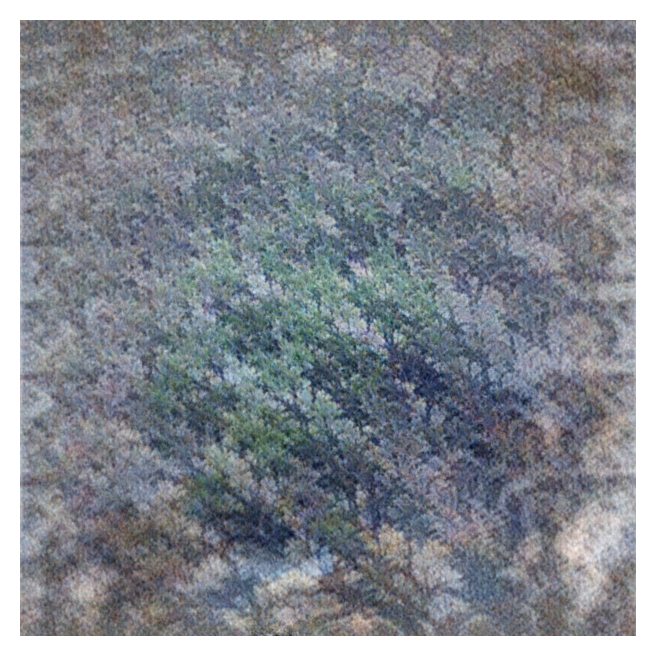

In [27]:
t = img.copy()
t = t - t.min()
t = t / t.max()
t = t * 255.0
t = t.astype(np.uint8)
cv2.imwrite('baseline_fv.png', t[...,::-1])
show(t.astype(np.float32))

In [28]:
np.save('baseline_fv.npy', img)

In [13]:
from tqdm import tqdm
import PIL
from PIL import Image

sz = 2048

optimizer_class = Nadam
learning_rate = 1.0
initialization_std = 1.0

nb_steps = 1000

# Works for every model that are approximately in the range (-1, 1)
noise_std = 0.080
box_average_size = tf.cast(np.linspace(0.45, 0.30, nb_steps), tf.float32)
box_size_std = 0.05

magnitude_template, phase = init_buffer(size=sz, std=initialization_std)
phase = tf.Variable(phase, trainable=True)
magnitude_alpha = tf.Variable(tf.zeros(magnitude_template.shape), trainable=True)

optimizer = optimizer_class(learning_rate)
transparency = tf.zeros((magnitude_template.shape[1], magnitude_template.shape[1], 3))
for i in tqdm(range(nb_steps)):

  grads, grads_img, grads_alpha, loss = up_neurons(model, magnitude_template, magnitude_alpha,
                                                            phase,
                                                            box_average_size=box_average_size[i],
                                                            box_size_std=box_size_std,
                                                            noise_std=noise_std,
                                                            nb_crops=32)
  optimizer.apply_gradients(zip([grads, grads_alpha], [phase, magnitude_alpha]))

  transparency += tf.abs(grads_img)

  if i == nb_steps-1 or (i+1) % 200 == 0: # if you want to plot every 25 steps
  #if i == nb_steps-1: # if you want to plot every 25 steps
    set_size(4, 4)
    img = fft_to_rgb(magnitude_template, magnitude_alpha, phase).numpy()
    viz = plot_alpha(img, transparency)
    plt.tight_layout()
    #plt.savefig(f'{logit_id}.png', dpi=350)
    #fn = f'flexiln_{vector_id}.npy'
    #np.save(fn, [img, transparency])
    #!cp {fn} "/content/drive/MyDrive/  temp/ferroviaire"
    plt.show()
    print(float(loss))



Output hidden; open in https://colab.research.google.com to view.

In [14]:
from tqdm import tqdm
import PIL
from PIL import Image

sz = 2048

optimizer_class = Nadam
learning_rate = 1.0
initialization_std = 1.0

nb_steps = 1000

# Works for every model that are approximately in the range (-1, 1)
noise_std = 0.080
box_average_size = tf.cast(np.linspace(0.45, 0.30, nb_steps), tf.float32)
box_size_std = 0.05

magnitude_template, phase = init_buffer(size=sz, std=initialization_std)
phase = tf.Variable(phase, trainable=True)
magnitude_alpha = tf.Variable(tf.zeros(magnitude_template.shape), trainable=True)

optimizer = optimizer_class(learning_rate)
transparency = tf.zeros((magnitude_template.shape[1], magnitude_template.shape[1], 3))
for i in tqdm(range(nb_steps)):

  grads, grads_img, grads_alpha, loss = up_neurons(model, magnitude_template, magnitude_alpha,
                                                            phase,
                                                            box_average_size=box_average_size[i],
                                                            box_size_std=box_size_std,
                                                            noise_std=noise_std,
                                                            nb_crops=32)
  optimizer.apply_gradients(zip([grads, grads_alpha], [phase, magnitude_alpha]))

  transparency += tf.abs(grads_img)

  if i == nb_steps-1 or (i+1) % 200 == 0: # if you want to plot every 25 steps
  #if i == nb_steps-1: # if you want to plot every 25 steps
    set_size(4, 4)
    img = fft_to_rgb(magnitude_template, magnitude_alpha, phase).numpy()
    viz = plot_alpha(img, transparency)
    plt.tight_layout()
    #plt.savefig(f'{logit_id}.png', dpi=350)
    #fn = f'flexiln_{vector_id}.npy'
    #np.save(fn, [img, transparency])
    #!cp {fn} "/content/drive/MyDrive/  temp/ferroviaire"
    plt.show()
    print(float(loss))



Output hidden; open in https://colab.research.google.com to view.

In [15]:
from tqdm import tqdm
import PIL
from PIL import Image

sz = 2048

optimizer_class = Nadam
learning_rate = 1.0
initialization_std = 1.0

nb_steps = 1000

# Works for every model that are approximately in the range (-1, 1)
noise_std = 0.080
box_average_size = tf.cast(np.linspace(0.45, 0.30, nb_steps), tf.float32)
box_size_std = 0.05

magnitude_template, phase = init_buffer(size=sz, std=initialization_std)
phase = tf.Variable(phase, trainable=True)
magnitude_alpha = tf.Variable(tf.zeros(magnitude_template.shape), trainable=True)

optimizer = optimizer_class(learning_rate)
transparency = tf.zeros((magnitude_template.shape[1], magnitude_template.shape[1], 3))
for i in tqdm(range(nb_steps)):

  grads, grads_img, grads_alpha, loss = up_neurons(model, magnitude_template, magnitude_alpha,
                                                            phase,
                                                            box_average_size=box_average_size[i],
                                                            box_size_std=box_size_std,
                                                            noise_std=noise_std,
                                                            nb_crops=32)
  optimizer.apply_gradients(zip([grads, grads_alpha], [phase, magnitude_alpha]))

  transparency += tf.abs(grads_img)

  if i == nb_steps-1 or (i+1) % 200 == 0: # if you want to plot every 25 steps
  #if i == nb_steps-1: # if you want to plot every 25 steps
    set_size(4, 4)
    img = fft_to_rgb(magnitude_template, magnitude_alpha, phase).numpy()
    viz = plot_alpha(img, transparency)
    plt.tight_layout()
    #plt.savefig(f'{logit_id}.png', dpi=350)
    #fn = f'flexiln_{vector_id}.npy'
    #np.save(fn, [img, transparency])
    #!cp {fn} "/content/drive/MyDrive/  temp/ferroviaire"
    plt.show()
    print(float(loss))



Output hidden; open in https://colab.research.google.com to view.

In [17]:
from tqdm import tqdm
import PIL
from PIL import Image

sz = 2048

optimizer_class = Nadam
learning_rate = 1.0
initialization_std = 1.0

nb_steps = 1000

# Works for every model that are approximately in the range (-1, 1)
noise_std = 0.080
box_average_size = tf.cast(np.linspace(0.80, 0.50, nb_steps), tf.float32)
box_size_std = 0.05

magnitude_template, phase = init_buffer(size=sz, std=initialization_std)
phase = tf.Variable(phase, trainable=True)
magnitude_alpha = tf.Variable(tf.zeros(magnitude_template.shape), trainable=True)

optimizer = optimizer_class(learning_rate)
transparency = tf.zeros((magnitude_template.shape[1], magnitude_template.shape[1], 3))
for i in tqdm(range(nb_steps)):

  grads, grads_img, grads_alpha, loss = up_neurons(model, magnitude_template, magnitude_alpha,
                                                            phase,
                                                            box_average_size=box_average_size[i],
                                                            box_size_std=box_size_std,
                                                            noise_std=noise_std,
                                                            nb_crops=32)
  optimizer.apply_gradients(zip([grads, grads_alpha], [phase, magnitude_alpha]))

  transparency += tf.abs(grads_img)

  if i == nb_steps-1 or (i+1) % 200 == 0: # if you want to plot every 25 steps
  #if i == nb_steps-1: # if you want to plot every 25 steps
    set_size(4, 4)
    img = fft_to_rgb(magnitude_template, magnitude_alpha, phase).numpy()
    viz = plot_alpha(img, transparency)
    plt.tight_layout()
    #plt.savefig(f'{logit_id}.png', dpi=350)
    #fn = f'flexiln_{vector_id}.npy'
    #np.save(fn, [img, transparency])
    #!cp {fn} "/content/drive/MyDrive/  temp/ferroviaire"
    plt.show()
    print(float(loss))



Output hidden; open in https://colab.research.google.com to view.